In [10]:
import requests, json, datetime, os, time, sqlite3
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import ForeignKey, Column, String, Integer, DateTime
from sqlalchemy.ext.declarative import declarative_base
from pprint import pprint
from dateutil.relativedelta import relativedelta

In [11]:
Base = declarative_base()

class ObjetPerdu(Base):
    __tablename__ = 'ObjetPerdu'

    id = Column(Integer, primary_key=True)
    date_heure_decouverte_OT = Column(DateTime, nullable=False)
    date_heure_restitution_OT = Column(DateTime, nullable=False)
    nom_gare_origine_OT = Column(String(100), nullable=False)
    code_UIC_gare_origine_OT = Column(String(100), nullable=False)
    nature_OT = Column(String(100), nullable=False)
    type_OT = Column(String(100), nullable=False)
    

    def __init__(self, id, date_heure_decouverte_OT, date_heure_decouverte_OT, nom_gare_origine_OT, code_UIC_gare_origine_OT, nature_OT, type_OT):
        self.id_OT = id
        self.date_heure_decouverte_OT = date_heure_decouverte_OT
        self.date_heure_decouverte_OT = date_heure_decouverte_OT
        self.nom_gare_origine_OT = nom_gare_origine_OT
        self.code_UIC_gare_origine_OT = code_UIC_gare_origine_OT
        self.nature_OT = nature_OT
        self.type_OT = type_OT

In [12]:
URL = "https://ressources.data.sncf.com/api/records/1.0/search/"
params = {
    "dataset" : "objets-trouves-restitution",
    "rows" : "-1",
}

In [13]:
start_date = datetime.datetime.strptime("01/01/2016","%d/%m/%Y")
end_date = datetime.datetime.strptime("31/12/2021","%d/%m/%Y")
current_date = start_date
objetsPerdus = []
start0 = time.process_time()
cpt = 0

while(current_date <= end_date):
    params["refine.date"] = str(current_date.year) + "/" + str(current_date.month)
    print("Retrieving month: " + str(current_date.year) + "/" + str(current_date.month))
    start1 = time.process_time()
    response_for_one_month = requests.get(URL, params = params)
    if response_for_one_month.status_code != 200:
        print("ERREUR API code = ", response_for_one_month.status_code)
    print("Temps d'execution de la requête API:", time.process_time() - start1)
    print("Code retour correspondant :", response_for_one_month)
    for item in response_for_one_month.json()['records']:
        start2 = time.process_time()
        try:
            date_OT = datetime.datetime.strptime(item['fields']['date'], '%Y-%m-%dT%H:%M:%S+00:00')
        except KeyError:
            date_OT = datetime.datetime.now()
        try:
            gc_obo_date_heure_restitution_c = datetime.datetime.strptime(item['fields']['gc_obo_date_heure_restitution_c'], '%Y-%m-%dT%H:%M:%S+00:00')
        except KeyError:
            gc_obo_date_heure_restitution_c = datetime.datetime.now()
        try:
            gc_obo_gare_origine_r_name = item['fields']['gc_obo_gare_origine_r_name']
        except KeyError:
            gc_obo_gare_origine_r_name = ""
        try:
            gc_obo_gare_origine_r_code_uic_c = item['fields']['gc_obo_gare_origine_r_code_uic_c']
        except KeyError:
            gc_obo_gare_origine_r_code_uic_c = ""
        try:
            gc_obo_nature_c = item['fields']['gc_obo_nature_c']
        except KeyError:
            gc_obo_nature_c = ""
        try:
            gc_obo_type_c = item['fields']['gc_obo_type_c']
        except KeyError:
            gc_obo_type_c = ""

        objetsPerdus.append(ObjetPerdu(
            cpt,
            date_OT,
            gc_obo_date_heure_restitution_c,
            gc_obo_gare_origine_r_name,
            gc_obo_gare_origine_r_code_uic_c,
            gc_obo_nature_c,
            gc_obo_type_c))

        cpt += 1
    
    print("Temps des manips pour un mois :", time.process_time() - start2)
    print("Pour le mois :",current_date,", le nombre d'enregistrements total atteint :",cpt)

    current_date += relativedelta(months=+1)

print("Temps total de l'étape extraction :", time.process_time() - start0)

Retrieving month: 2016/1
Temps d'execution de la requête API: 0.06836437800000184
Code retour correspondant : <Response [200]>
Temps des manips pour un mois : 0.0037868450000004827
Pour le mois : 2016-01-01 00:00:00 , le nombre d'enregistrements total atteint : 7243
Retrieving month: 2016/2
Temps d'execution de la requête API: 0.061194377999999716
Code retour correspondant : <Response [200]>
Temps des manips pour un mois : 0.0029362000000006105
Pour le mois : 2016-02-01 00:00:00 , le nombre d'enregistrements total atteint : 14417
Retrieving month: 2016/3
Temps d'execution de la requête API: 0.06118661700000061
Code retour correspondant : <Response [200]>
Temps des manips pour un mois : 0.003008920000002746
Pour le mois : 2016-03-01 00:00:00 , le nombre d'enregistrements total atteint : 21869
Retrieving month: 2016/4
Temps d'execution de la requête API: 0.06314680000000195
Code retour correspondant : <Response [200]>
Temps des manips pour un mois : 0.004436805999997517
Pour le mois : 20

In [15]:
# Fichier SQLite de test
bdd_locale = "lit.sqlite"

if(not os.path.isfile(f"{bdd_locale}")):
    engine = create_engine(f"sqlite:///{bdd_locale}", echo=False)
    Base.metadata.create_all(bind=engine)
    Session = sessionmaker(bind=engine)
    session = Session()
else:
    engine = create_engine(f"sqlite:///{bdd_locale}", echo=False)
    Session = sessionmaker(bind=engine)
    session = Session()
    
start = time.process_time()
session.add_all(objetsPerdus)
print("Temps d'ajout des objets sur SQLite :", time.process_time() - start)
start = time.process_time()
session.commit()
print("Temps du commit en base SQLite pour",cpt,"objets :", time.process_time() - start)

Temps d'ajout des objets sur SQLite : 3.483889935999997


OperationalError: (sqlite3.OperationalError) no such table: ObjetPerdu
[SQL: INSERT INTO "ObjetPerdu" ("date_heure_decouverte_OT", "date_heure_restitution_OT", "nom_gare_origine_OT", "code_UIC_gare_origine_OT", "nature_OT", "type_OT") VALUES (?, ?, ?, ?, ?, ?)]
[parameters: ('2016-01-01 05:29:11.000000', '2022-12-22 06:49:10.918034', 'Lyon Part Dieu', '0087723197', 'Sac à dos', 'Bagagerie: sacs, valises, cartables')]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [16]:
Session.close_all()
session.rollback()
session.close()

/tmp/ipykernel_82643/2135109175.py:1: SADeprecationWarning: The Session.close_all() method is deprecated and will be removed in a future release.  Please refer to session.close_all_sessions(). (deprecated since: 1.3)
  Session.close_all()


In [18]:
conn = sqlite3.connect('lit.sqlite')

# Créer un curseur
cursor = conn.cursor()
#cursor.execute("ALTER TABLE ObjetTrouve RENAME COLUMN code_UIC_gare_origine_OT TO 'Code UIC';")

In [19]:
import pandas as pd

df_freq = pd.read_csv('frequentation.csv',index_col="id",dtype={"Code UIC":"object"})
df_freq = df_freq.drop(df_freq[["del1","del2"]],axis=1)
df_OT = pd.read_sql_query('SELECT * FROM ObjetTrouve', conn, index_col="id")
# df_OT = pd.read_sql_query('SELECT * FROM ObjetTrouve', conn, index_col="id", dtype={
#     "date_heure_decouverte_OT" : 'datetime64[ns]',
#     "date_heure_restitution_OT" : 'datetime64[ns]',
#     "nom_gare_origine_OT" : 'string',
#     "Code UIC" : 'string',
#     "nature_OT" : 'string',
#     "type_OT" : 'string',
#     "lat" : 'string',
#     "long" : 'string',
#     "frequentation" : 'int64',
#     "region" : 'string'
# })


In [20]:
df_OT['date_heure_decouverte_OT'] = pd.to_datetime(df_OT['date_heure_decouverte_OT'])
df_OT['date_heure_restitution_OT'] = pd.to_datetime(df_OT['date_heure_restitution_OT'])
df_OT['frequentation'] = pd.to_numeric(df_OT['frequentation'])
df_OT['lat'] = pd.to_numeric(df_OT['lat'])
df_OT['long'] = pd.to_numeric(df_OT['long'])
df_OT['frequentation'] = pd.to_numeric(df_OT['frequentation'])

# df_OT.rename(columns={'code_UIC_gare_origine_OT': 'Code UIC'}, inplace=True)

In [22]:
df_OT["Code UIC"].replace('', 0, inplace=True)

In [23]:
df_OT['Code UIC'] = df_OT['Code UIC'].map(int)

In [ ]:
df_OT.columns

In [24]:
df_OT["Code UIC"] = df_OT["Code UIC"].map(str)

In [ ]:
df_OT.dtypes

In [25]:
df_freq.fillna(value=0)

,Code UIC,CP,2021,2020,2019,2018,2017,2016,region
id,,,,,,,,,
0,87481614,44170,27466,22773,38473,38027,35637,33021,Pays de la Loire
1,87271460,93290,3460437,2177954,7971396,7590098,7199779,6690263,Île-de-France
2,87757559,83530,25094,15390,22284,15093,14154,19240,Provence-Alpes-Côte d'Azur
3,87734129,63260,55143,50677,75954,70745,77218,78088,Auvergne-Rhône-Alpes
4,87775858,30220,8201,5683,6146,5311,4822,3546,Occitanie
...,...,...,...,...,...,...,...,...,...
2965,87286229,59118,127,21,919,976,1093,745,Hauts-de-France
2966,87281436,62910,86007,82999,113082,96927,101732,95636,Hauts-de-France
2967,87214676,67130,85596,79288,88851,91479,100373,103452,Grand Est


In [26]:
temp = pd.merge(df_OT, df_freq, on='Code UIC', how='left')

In [27]:
df_OT = df_OT.drop(df_OT[["lat","long","frequentation","region"]],axis=1)

In [28]:
temp.rename(columns={'2016': 'an_2016'}, inplace=True)
temp.rename(columns={'2017': 'an_2017'}, inplace=True)
temp.rename(columns={'2018': 'an_2018'}, inplace=True)
temp.rename(columns={'2019': 'an_2019'}, inplace=True)
temp.rename(columns={'2020': 'an_2020'}, inplace=True)
temp.rename(columns={'2021': 'an_2021'}, inplace=True)
temp.rename(columns={'Code UIC': 'uic'}, inplace=True)


In [29]:
df_OT.rename(columns={'Code UIC': 'uic'}, inplace=True)

In [32]:
temp

,date_heure_decouverte_OT,date_heure_restitution_OT,nom_gare_origine_OT,uic,nature_OT,type_OT,lat,long,frequentation,region_x,CP,an_2021,an_2020,an_2019,an_2018,an_2017,an_2016,region_y
0,2016-01-01 05:29:11,2022-12-21 11:20:58.359848,Lyon Part Dieu,87723197,Sac à dos,"Bagagerie: sacs, valises, cartables",NaN,NaN,NaN,None,69003.0,26187679.0,19541666.0,32587523.0,32555240.0,34874317.0,32525629.0,Auvergne-Rhône-Alpes
1,2016-01-01 06:44:54,2022-12-21 11:20:58.359938,Marne-la-Vallée Chessy,87111849,"Porte-monnaie, portefeuille","Porte-monnaie / portefeuille, argent, titres",NaN,NaN,NaN,None,77111.0,3312209.0,2492919.0,5432886.0,5996489.0,6009276.0,5418784.0,Île-de-France
2,2016-01-01 07:15:22,2022-12-21 11:20:58.359978,Paris Montparnasse,87391003,Autre livre,"Livres, articles de papéterie",NaN,NaN,NaN,None,75015.0,41043477.0,32439307.0,61374035.0,59174531.0,57752741.0,55162747.0,Île-de-France
3,2016-01-01 07:21:38,2022-12-21 11:20:58.360012,Paris Montparnasse,87391003,Lunettes,Optique,NaN,NaN,NaN,None,75015.0,41043477.0,32439307.0,61374035.0,59174531.0,57752741.0,55162747.0,Île-de-France
4,2016-01-01 09:32:12,2016-01-03 16:47:44.000000,Bordeaux Saint-Jean,87581009,"Ordinateur, ordinateur portable, notebook prot...","Appareils électroniques, informatiques, appare...",NaN,NaN,NaN,None,33800.0,16454662.0,11184093.0,17675655.0,16080989.0,14979299.0,12198403.0,Nouvelle-Aquitaine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481297,2021-12-15 17:14:16,2022-12-21 11:26:32.384789,Mulhouse,87182063,Vélo,"Vélos, trottinettes, accessoires 2 roues",NaN,NaN,NaN,None,68100.0,4074689.0,3408899.0,5320370.0,5055333.0,5174727.0,4946420.0,Grand Est
481298,2021-12-15 17:39:56,2022-12-21 11:26:32.384817,Trouville - Deauville,87444372,Lunettes,Optique,NaN,NaN,NaN,None,14200.0,650092.0,493350.0,819956.0,666054.0,775823.0,734865.0,Normandie
481299,2021-12-15 18:47:47,2021-12-24 09:28:13.000000,Grenoble,87747006,Sac à dos,"Bagagerie: sacs, valises, cartables",NaN,NaN,NaN,None,38000.0,6150709.0,4781532.0,7796571.0,7057612.0,7674268.0,7237980.0,Auvergne-Rhône-Alpes
481300,2021-12-15 20:59:02,2022-12-21 11:26:32.384880,Angers Saint-Laud,87484006,Autres divers,Divers,NaN,NaN,NaN,None,49100.0,4662966.0,3433325.0,5739760.0,5372470.0,5647027.0,5368048.0,Pays de la Loire


In [34]:
temp = temp.drop(temp[["lat","long","frequentation","region_x"]],axis=1)

In [96]:
temp.dtypes

date_heure_decouverte_OT     datetime64[ns]
date_heure_restitution_OT    datetime64[ns]
nom_gare_origine_OT                  object
uic                                  object
nature_OT                            object
type_OT                              object
CP                                  float64
an_2021                             float64
an_2020                             float64
an_2019                             float64
an_2018                             float64
an_2017                             float64
an_2016                             float64
region_y                             object
dtype: object

### Calculez entre 2016 et 2021 la somme du nombre d’objets perdus par semaine. Afficher sur un histogramme la répartition de ces valeurs. (un point correspond à une semaine dont la valeur est la somme).

In [60]:
timing = temp.groupby(pd.Grouper(key='date_heure_decouverte_OT', freq='W'))



In [61]:
timing

In [62]:
timing = timing['nature_OT'].apply(lambda x: x.value_counts()).sum()


In [63]:
timing

481302

In [72]:
question_1 = temp.groupby(pd.Grouper(key='date_heure_decouverte_OT', freq='W')).count()

In [101]:
question_1

,date_heure_restitution_OT,nom_gare_origine_OT,uic,nature_OT,type_OT,CP,an_2021,an_2020,an_2019,an_2018,an_2017,an_2016,region_y
date_heure_decouverte_OT,,,,,,,,,,,,,
2016-01-03,331,331,331,331,331,291,291,291,291,291,291,291,291
2016-01-10,1736,1736,1736,1736,1736,1624,1624,1624,1624,1624,1624,1624,1624
2016-01-17,1822,1822,1822,1822,1822,1695,1695,1695,1695,1695,1695,1695,1695
2016-01-24,1674,1674,1674,1674,1674,1587,1587,1587,1587,1587,1587,1587,1587
2016-01-31,1680,1680,1680,1680,1680,1562,1562,1562,1562,1562,1562,1562,1562
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-05,1277,1277,1277,1277,1277,1211,1211,1211,1211,1211,1211,1211,1211
2021-12-12,1358,1358,1358,1358,1358,1307,1307,1307,1307,1307,1307,1307,1307
2021-12-19,1462,1462,1462,1462,1462,1363,1363,1363,1363,1363,1363,1363,1363


In [79]:
timing = timing["nature_OT"]

In [74]:
import matplotlib.pyplot as plt

In [89]:
timing.dtypes

dtype('int64')

<AxesSubplot: xlabel='date_heure_decouverte_OT'>

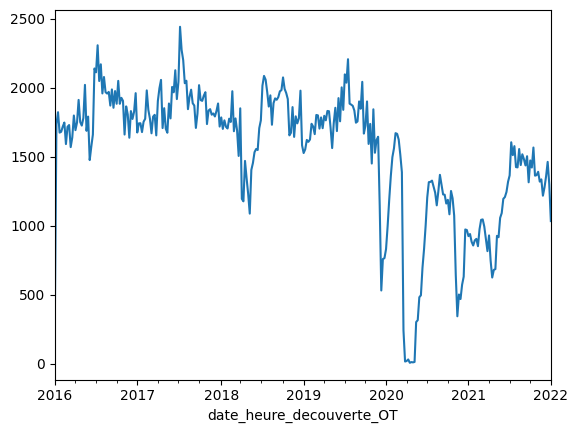

In [82]:
timing.plot(x='lost_item', y='date_heure_decouverte_OT', )


(array([  8.,   6.,  10.,  20.,  23.,  36.,  65., 100.,  41.,   5.]),
 array([   6. ,  249.5,  493. ,  736.5,  980. , 1223.5, 1467. , 1710.5,
        1954. , 2197.5, 2441. ]),
 <BarContainer object of 10 artists>)

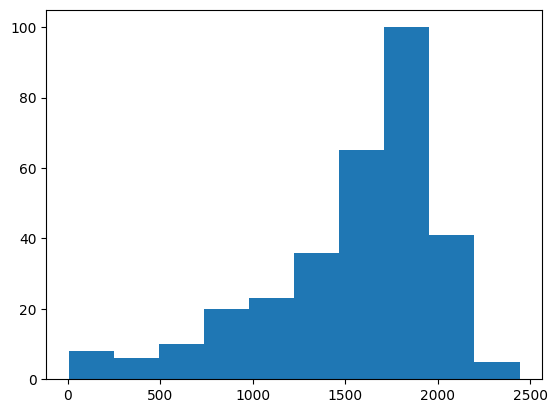

In [90]:
plt.hist(timing)


# refaire mais en mettant de meilleurs coordoné pour y 

# Afficher l’évolution du nombre d’objets perdus à l’aide d’un plotly sur la période 2016-2021. On peut choisir d’afficher ou non certains types d’objet.

In [91]:
temp.to_csv('data_objet_and_freq.csv', index=False)

PARTIE ANALYSE DONNEE JUPYTER



In [93]:
df = pd.read_csv('data_objet_and_freq.csv')

In [95]:
df.dtypes

date_heure_decouverte_OT      object
date_heure_restitution_OT     object
nom_gare_origine_OT           object
uic                            int64
nature_OT                     object
type_OT                       object
CP                           float64
an_2021                      float64
an_2020                      float64
an_2019                      float64
an_2018                      float64
an_2017                      float64
an_2016                      float64
region_y                      object
dtype: object

In [97]:
df['date_heure_decouverte_OT'] = pd.to_datetime(df['date_heure_decouverte_OT'])
df['date_heure_restitution_OT'] = pd.to_datetime(df['date_heure_restitution_OT'])

In [99]:
tri = list(df['type_OT'].unique())

In [100]:
tri

['Bagagerie: sacs, valises, cartables',
 'Porte-monnaie / portefeuille, argent, titres',
 'Livres, articles de papéterie',
 'Optique',
 'Appareils électroniques, informatiques, appareils photo',
 'Vêtements, chaussures',
 'Articles médicaux',
 "Pièces d'identités et papiers personnels",
 'Clés, porte-clés, badge magnétique',
 'Divers',
 'Vélos, trottinettes, accessoires 2 roues',
 'Parapluies',
 'Bijoux, montres',
 "Articles d'enfants, de puériculture",
 'Instruments de musique',
 'Articles de sport, loisirs, camping']

In [ ]:
df

In [103]:
df_carte = df

In [104]:
df_carte['year'] = df_carte['date_heure_decouverte_OT'].dt.year


In [105]:
df_carte

,date_heure_decouverte_OT,date_heure_restitution_OT,nom_gare_origine_OT,uic,nature_OT,type_OT,CP,an_2021,an_2020,an_2019,an_2018,an_2017,an_2016,region_y,year
0,2016-01-01 05:29:11,2022-12-21 11:20:58.359848,Lyon Part Dieu,87723197,Sac à dos,"Bagagerie: sacs, valises, cartables",69003.0,26187679.0,19541666.0,32587523.0,32555240.0,34874317.0,32525629.0,Auvergne-Rhône-Alpes,2016
1,2016-01-01 06:44:54,2022-12-21 11:20:58.359938,Marne-la-Vallée Chessy,87111849,"Porte-monnaie, portefeuille","Porte-monnaie / portefeuille, argent, titres",77111.0,3312209.0,2492919.0,5432886.0,5996489.0,6009276.0,5418784.0,Île-de-France,2016
2,2016-01-01 07:15:22,2022-12-21 11:20:58.359978,Paris Montparnasse,87391003,Autre livre,"Livres, articles de papéterie",75015.0,41043477.0,32439307.0,61374035.0,59174531.0,57752741.0,55162747.0,Île-de-France,2016
3,2016-01-01 07:21:38,2022-12-21 11:20:58.360012,Paris Montparnasse,87391003,Lunettes,Optique,75015.0,41043477.0,32439307.0,61374035.0,59174531.0,57752741.0,55162747.0,Île-de-France,2016
4,2016-01-01 09:32:12,2016-01-03 16:47:44.000000,Bordeaux Saint-Jean,87581009,"Ordinateur, ordinateur portable, notebook prot...","Appareils électroniques, informatiques, appare...",33800.0,16454662.0,11184093.0,17675655.0,16080989.0,14979299.0,12198403.0,Nouvelle-Aquitaine,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481297,2021-12-15 17:14:16,2022-12-21 11:26:32.384789,Mulhouse,87182063,Vélo,"Vélos, trottinettes, accessoires 2 roues",68100.0,4074689.0,3408899.0,5320370.0,5055333.0,5174727.0,4946420.0,Grand Est,2021
481298,2021-12-15 17:39:56,2022-12-21 11:26:32.384817,Trouville - Deauville,87444372,Lunettes,Optique,14200.0,650092.0,493350.0,819956.0,666054.0,775823.0,734865.0,Normandie,2021
481299,2021-12-15 18:47:47,2021-12-24 09:28:13.000000,Grenoble,87747006,Sac à dos,"Bagagerie: sacs, valises, cartables",38000.0,6150709.0,4781532.0,7796571.0,7057612.0,7674268.0,7237980.0,Auvergne-Rhône-Alpes,2021
481300,2021-12-15 20:59:02,2022-12-21 11:26:32.384880,Angers Saint-Laud,87484006,Autres divers,Divers,49100.0,4662966.0,3433325.0,5739760.0,5372470.0,5647027.0,5368048.0,Pays de la Loire,2021


In [399]:
import pandas as pd

# Load the data into a dataframe
df = pd.read_csv('data_objet_and_freq.csv')

# Convert the "date_heure_restitution_OT" column to datetime
df['date_heure_decouverte_OT'] = pd.to_datetime(df['date_heure_decouverte_OT'])

# Extract the month from the datetime objects
df['month'] = df['date_heure_decouverte_OT'].dt.month

# Convert the "month" column to a categorical data type


# Use one-hot encoding to transform the "type_OT" column into separate columns
df_onehot = pd.get_dummies(df, columns=['type_OT'])

# Create a cross-tabulation of the data by month and each type of found object, and count the number of found items for each group


# Calculate the correlations between the rows (types of found objects) and the "month" column of the cross-tabulation
#corr = found_objects_crosstab.corr()

# Print the result
#print(corr)


In [305]:
az = df_onehot.groupby(df_onehot['month']).sum()
az = az.reset_index()
az

/tmp/ipykernel_82643/2194627922.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  az = df_onehot.groupby(df_onehot['month']).sum()


,month,uic,CP,an_2021,an_2020,an_2019,an_2018,an_2017,an_2016,"type_OT_Appareils électroniques, informatiques, appareils photo",...,"type_OT_Clés, porte-clés, badge magnétique",type_OT_Divers,type_OT_Instruments de musique,"type_OT_Livres, articles de papéterie",type_OT_Optique,type_OT_Parapluies,type_OT_Pièces d'identités et papiers personnels,"type_OT_Porte-monnaie / portefeuille, argent, titres","type_OT_Vélos, trottinettes, accessoires 2 roues","type_OT_Vêtements, chaussures"
0,1,3410942839726,1.990999e+09,7.411317e+11,6.157099e+11,9.844237e+11,9.587321e+11,9.751678e+11,9.388439e+11,5887,...,1925,762,92,935,1812,500,3369,4534,499,4301
1,2,3410197776915,1.989956e+09,7.374167e+11,6.134193e+11,9.776446e+11,9.516815e+11,9.676429e+11,9.312514e+11,5966,...,1789,691,80,926,1933,474,3263,4543,541,4471
2,3,3306658994153,1.910154e+09,7.020113e+11,5.813049e+11,9.305130e+11,9.054868e+11,9.209499e+11,8.859471e+11,5913,...,1806,710,101,983,1939,564,3081,4510,585,4092
3,4,2814304517225,1.623649e+09,5.931821e+11,4.942474e+11,7.858575e+11,7.646182e+11,7.776762e+11,7.480562e+11,4915,...,1486,613,96,761,1848,285,2624,3885,515,3949
4,5,3074499688508,1.785015e+09,6.611438e+11,5.465662e+11,8.785989e+11,8.554271e+11,8.702038e+11,8.375188e+11,5325,...,1725,659,99,830,2183,436,2787,4233,587,4663
5,6,3487618003465,2.014734e+09,7.296333e+11,6.060437e+11,9.689099e+11,9.424576e+11,9.578694e+11,9.211702e+11,6202,...,1852,787,84,866,2501,442,3102,5078,723,5886
6,7,4323928417721,2.466306e+09,8.859350e+11,7.292934e+11,1.176645e+12,1.144137e+12,1.163277e+12,1.117831e+12,7118,...,2023,1069,166,974,3207,276,3677,5932,790,7257
7,8,4042285326948,2.302633e+09,8.501764e+11,6.970806e+11,1.130567e+12,1.099886e+12,1.118751e+12,1.075750e+12,6380,...,1744,1068,159,801,2878,302,3487,5657,713,6692
8,9,3807930153580,2.198428e+09,7.758728e+11,6.423112e+11,1.028945e+12,9.999769e+11,1.016095e+12,9.763715e+11,6490,...,2033,875,114,936,2464,328,3213,5363,819,6697
9,10,3916973743325,2.262128e+09,8.149038e+11,6.807653e+11,1.076904e+12,1.047624e+12,1.064729e+12,1.023914e+12,6717,...,1977,942,102,1045,2220,425,3372,5368,789,5902


In [174]:
az.columns

Index(['month', 'uic', 'CP', 'an_2021', 'an_2020', 'an_2019', 'an_2018',
       'an_2017', 'an_2016',
       'type_OT_Appareils électroniques, informatiques, appareils photo',
       'type_OT_Articles d'enfants, de puériculture',
       'type_OT_Articles de sport, loisirs, camping',
       'type_OT_Articles médicaux',
       'type_OT_Bagagerie: sacs, valises, cartables',
       'type_OT_Bijoux, montres', 'type_OT_Clés, porte-clés, badge magnétique',
       'type_OT_Divers', 'type_OT_Instruments de musique',
       'type_OT_Livres, articles de papéterie', 'type_OT_Optique',
       'type_OT_Parapluies',
       'type_OT_Pièces d'identités et papiers personnels',
       'type_OT_Porte-monnaie / portefeuille, argent, titres',
       'type_OT_Vélos, trottinettes, accessoires 2 roues',
       'type_OT_Vêtements, chaussures'],
      dtype='object')

In [306]:
bon_df = az[["type_OT_Appareils électroniques, informatiques, appareils photo",
       "type_OT_Articles d'enfants, de puériculture",
       'type_OT_Articles de sport, loisirs, camping',
       'type_OT_Articles médicaux',
       'type_OT_Bagagerie: sacs, valises, cartables',
       'type_OT_Bijoux, montres', 'type_OT_Clés, porte-clés, badge magnétique',
       'type_OT_Divers', 'type_OT_Instruments de musique',
       'type_OT_Livres, articles de papéterie', 'type_OT_Optique',
       'type_OT_Parapluies',
       "type_OT_Pièces d'identités et papiers personnels",
       'type_OT_Porte-monnaie / portefeuille, argent, titres',
       'type_OT_Vélos, trottinettes, accessoires 2 roues',
       'type_OT_Vêtements, chaussures',
       "month"]]

In [307]:
df_onehot = pd.get_dummies(bon_df, columns=['month'])


In [308]:
import seaborn as sns

In [309]:
correlation_df = df_onehot.corr()

In [268]:
correlation_df.columns

Index(['type_OT_Appareils électroniques, informatiques, appareils photo',
       'type_OT_Articles d'enfants, de puériculture',
       'type_OT_Articles de sport, loisirs, camping',
       'type_OT_Articles médicaux',
       'type_OT_Bagagerie: sacs, valises, cartables',
       'type_OT_Bijoux, montres', 'type_OT_Clés, porte-clés, badge magnétique',
       'type_OT_Divers', 'type_OT_Instruments de musique',
       'type_OT_Livres, articles de papéterie', 'type_OT_Optique',
       'type_OT_Parapluies',
       'type_OT_Pièces d'identités et papiers personnels',
       'type_OT_Porte-monnaie / portefeuille, argent, titres',
       'type_OT_Vélos, trottinettes, accessoires 2 roues',
       'type_OT_Vêtements, chaussures', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12'],
      dtype='object')

In [310]:
correlation_df = correlation_df.drop(correlation_df[['month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']])

In [311]:
correlation_df.drop(correlation_df[['type_OT_Appareils électroniques, informatiques, appareils photo',
       "type_OT_Articles d'enfants, de puériculture",
       'type_OT_Articles de sport, loisirs, camping',
       'type_OT_Articles médicaux',
       'type_OT_Bagagerie: sacs, valises, cartables',
       'type_OT_Bijoux, montres', 'type_OT_Clés, porte-clés, badge magnétique',
       'type_OT_Divers', 'type_OT_Instruments de musique',
       'type_OT_Livres, articles de papéterie', 'type_OT_Optique',
       'type_OT_Parapluies',
       "type_OT_Pièces d'identités et papiers personnels",
       'type_OT_Porte-monnaie / portefeuille, argent, titres',
       'type_OT_Vélos, trottinettes, accessoires 2 roues',
       'type_OT_Vêtements, chaussures',]],axis = 1,inplace = True)

In [312]:
correlation_df

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
"type_OT_Appareils électroniques, informatiques, appareils photo",-0.051660,-0.012229,-0.038683,-0.536819,-0.332174,0.105567,0.562774,0.194413,0.249318,0.362621,-0.218371,-0.284756
"type_OT_Articles d'enfants, de puériculture",-0.136329,0.011467,-0.146522,-0.141426,-0.143974,-0.210228,0.546592,0.752997,-0.169456,-0.014015,-0.245903,-0.103203
"type_OT_Articles de sport, loisirs, camping",-0.163274,-0.112613,-0.147856,-0.207328,-0.143450,-0.031113,0.602161,0.700180,0.050387,-0.108207,-0.189707,-0.249179
type_OT_Articles médicaux,-0.095326,-0.309141,-0.287759,-0.383976,-0.031181,0.043654,0.428521,0.685099,0.171943,0.065035,-0.031181,-0.255687
"type_OT_Bagagerie: sacs, valises, cartables",0.112272,0.064992,-0.066317,-0.547281,-0.484313,-0.351070,0.410134,0.251532,0.016852,0.398959,0.061338,0.132903
"type_OT_Bijoux, montres",0.036182,0.209858,-0.218542,-0.554314,-0.276433,-0.108547,0.632468,0.244593,0.105653,0.256171,-0.241698,-0.085390
"type_OT_Clés, porte-clés, badge magnétique",0.224277,-0.012017,0.017519,-0.538468,-0.123215,0.097443,0.394549,-0.090203,0.411923,0.314625,-0.189239,-0.507194
type_OT_Divers,-0.092418,-0.240426,-0.200819,-0.403027,-0.307134,-0.040303,0.547561,0.545476,0.143144,0.282814,-0.132026,-0.102841
type_OT_Instruments de musique,-0.181204,-0.319999,-0.077108,-0.134939,-0.100241,-0.273734,0.674696,0.593732,0.073253,-0.065542,-0.169638,-0.019277
"type_OT_Livres, articles de papéterie",0.135709,0.104722,0.300969,-0.463360,-0.225798,-0.101853,0.269983,-0.325643,0.139152,0.514430,0.118494,-0.466803


In [288]:
from  scipy.stats import chi2_contingency  

In [ ]:
df_onehot = df_onehot.drop(df_onehot[['month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']],axis = 1,)

In [297]:
chi_squared_result =chi2_contingency(df_onehot)

In [300]:
bon_df

,"type_OT_Appareils électroniques, informatiques, appareils photo","type_OT_Articles d'enfants, de puériculture","type_OT_Articles de sport, loisirs, camping",type_OT_Articles médicaux,"type_OT_Bagagerie: sacs, valises, cartables","type_OT_Bijoux, montres","type_OT_Clés, porte-clés, badge magnétique",type_OT_Divers,type_OT_Instruments de musique,"type_OT_Livres, articles de papéterie",type_OT_Optique,type_OT_Parapluies,type_OT_Pièces d'identités et papiers personnels,"type_OT_Porte-monnaie / portefeuille, argent, titres","type_OT_Vélos, trottinettes, accessoires 2 roues","type_OT_Vêtements, chaussures",month
0,2746,80,63,64,7338,21,347,168,56,246,236,20,700,2139,158,578,1
1,2690,62,72,48,6834,27,321,150,50,232,225,35,686,1886,180,573,2
2,2782,73,82,44,6767,27,340,154,55,258,223,32,709,2125,186,583,3
3,2195,65,52,41,5327,18,265,116,56,204,201,8,564,1684,175,703,4
4,2338,75,61,48,5333,16,292,122,47,208,244,21,577,1799,196,827,5
5,2649,66,67,55,5487,35,345,149,60,227,285,15,613,2108,250,1164,6
6,2942,106,111,62,6929,31,363,181,86,207,349,13,769,2445,230,1307,7
7,2663,108,165,62,6542,24,342,154,87,176,297,20,663,2264,212,1097,8
8,2955,86,127,46,6626,20,368,175,76,224,269,17,750,2473,247,1480,9
9,3028,63,64,54,7670,28,379,190,71,265,261,26,742,2374,235,1421,10


In [298]:
df_onehot

,"type_OT_Appareils électroniques, informatiques, appareils photo","type_OT_Articles d'enfants, de puériculture","type_OT_Articles de sport, loisirs, camping",type_OT_Articles médicaux,"type_OT_Bagagerie: sacs, valises, cartables","type_OT_Bijoux, montres","type_OT_Clés, porte-clés, badge magnétique",type_OT_Divers,type_OT_Instruments de musique,"type_OT_Livres, articles de papéterie",type_OT_Optique,type_OT_Parapluies,type_OT_Pièces d'identités et papiers personnels,"type_OT_Porte-monnaie / portefeuille, argent, titres","type_OT_Vélos, trottinettes, accessoires 2 roues","type_OT_Vêtements, chaussures"
0,2746,80,63,64,7338,21,347,168,56,246,236,20,700,2139,158,578
1,2690,62,72,48,6834,27,321,150,50,232,225,35,686,1886,180,573
2,2782,73,82,44,6767,27,340,154,55,258,223,32,709,2125,186,583
3,2195,65,52,41,5327,18,265,116,56,204,201,8,564,1684,175,703
4,2338,75,61,48,5333,16,292,122,47,208,244,21,577,1799,196,827
5,2649,66,67,55,5487,35,345,149,60,227,285,15,613,2108,250,1164
6,2942,106,111,62,6929,31,363,181,86,207,349,13,769,2445,230,1307
7,2663,108,165,62,6542,24,342,154,87,176,297,20,663,2264,212,1097
8,2955,86,127,46,6626,20,368,175,76,224,269,17,750,2473,247,1480
9,3028,63,64,54,7670,28,379,190,71,265,261,26,742,2374,235,1421


In [299]:
print(chi_squared_result)

(44423.49897297777, 0.0, 165, array([[2.23438623e+03, 1.62063403e+02, 1.80246581e+02, 8.05343838e+01,
        4.69986977e+03, 1.40150342e+02, 6.69855849e+02, 3.00752874e+02,
        4.01584037e+01, 3.34042078e+02, 8.20885016e+02, 1.53950908e+02,
        1.17519279e+03, 1.80728358e+03, 2.36661057e+02, 1.92396674e+03],
       [2.10160753e+03, 1.52432764e+02, 1.69535404e+02, 7.57486173e+01,
        4.42057938e+03, 1.31821889e+02, 6.30049576e+02, 2.82880595e+02,
        3.77719852e+01, 3.14191582e+02, 7.72103814e+02, 1.44802355e+02,
        1.10535680e+03, 1.69988551e+03, 2.22597442e+02, 1.80963476e+03],
       [2.15672040e+03, 1.56430183e+02, 1.73981326e+02, 7.77350603e+01,
        4.53650531e+03, 1.35278806e+02, 6.46572090e+02, 2.90298898e+02,
        3.87625233e+01, 3.22430989e+02, 7.92351580e+02, 1.48599673e+02,
        1.13434384e+03, 1.74446356e+03, 2.28434870e+02, 1.85709089e+03],
       [1.74359792e+03, 1.26465787e+02, 1.40654986e+02, 6.28448126e+01,
        3.66753207e+03, 1.09365

<AxesSubplot: >

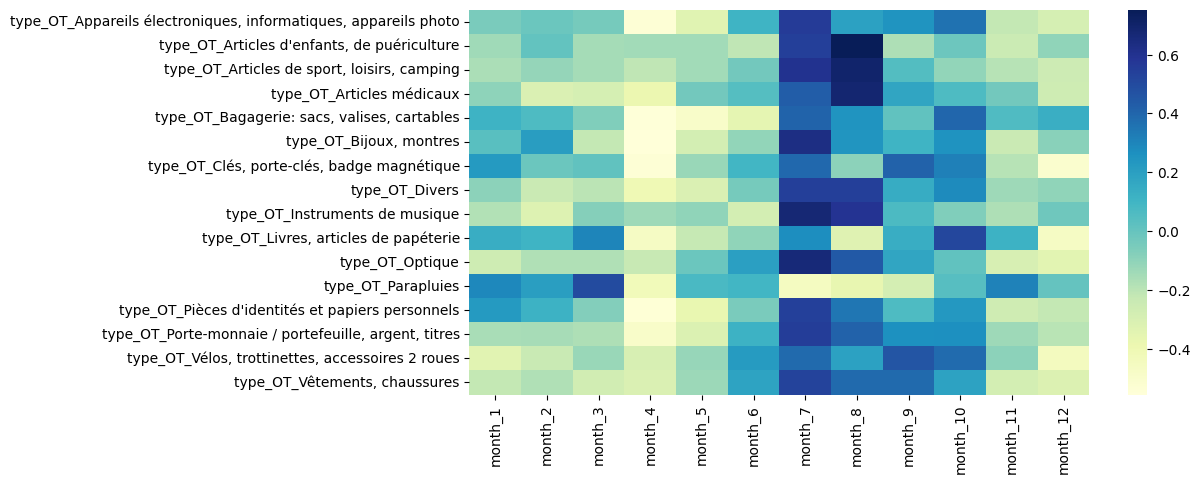

In [313]:
plt.figure(figsize=(10,5))
sns.heatmap(correlation_df, cmap="YlGnBu")




In [ ]:
# et la on realise on a fait un peu n'importe quoi , le mois 12 est toujours correlé aux type d'objet perdu , parce que on a fait la somme 
# des objets perdu , si on suppose que le type d'objet perdu ne represente pas de repartition particulière .
#  Comme la somme se cacul toujours le 12 (le 30)
# la somme des objet perdu par type est correlé au douxième mois 


Le mois est une variable categorielle et le type d'objet perdu est aussi une variable categorielle 
mais devait-on considerer le nombre d'objet perdu par type en fonction du mois ?


In [ ]:
# essayons de faire la heatmap 

In [ ]:
# verifions que nous avons bien fait la bonne analyse pour la question 3 

In [315]:
type = pd.crosstab(df['type_OT'],df["month"])

In [316]:
type

month,1,2,3,4,5,6,7,8,9,10,11,12
type_OT,,,,,,,,,,,,
"Appareils électroniques, informatiques, appareils photo",5887,5966,5913,4915,5325,6202,7118,6380,6490,6717,5553,5420
"Articles d'enfants, de puériculture",381,439,377,379,378,352,649,730,368,429,338,394
"Articles de sport, loisirs, camping",335,381,349,295,353,455,1030,1119,529,385,311,257
Articles médicaux,207,187,189,180,213,220,256,280,232,222,213,192
"Bagagerie: sacs, valises, cartables",13123,12903,12292,10054,10347,10967,14509,13771,12679,14457,12886,13219
"Bijoux, montres",382,412,338,280,328,357,485,418,394,420,334,361
"Clés, porte-clés, badge magnétique",1925,1789,1806,1486,1725,1852,2023,1744,2033,1977,1687,1504
Divers,762,691,710,613,659,787,1069,1068,875,942,743,757
Instruments de musique,92,80,101,96,99,84,166,159,114,102,93,106


In [318]:
resultat_test = chi2_contingency(type)

In [436]:
print(resultat_test[0])# est_ce la p- value ?

4834.730785504705


In [322]:
print(resultat_test[2])

165


donc on en déduit avoir 192-165 donc on a 27 variable dependante 

In [323]:
dff = pd.read_csv("merge_final.csv")

In [324]:
dff

,Unnamed: 0,temperature_moyenne,nb_lost_item
0,0,-9.3500,8
1,1,-8.0750,1
2,2,-8.0000,4
3,3,-7.9625,6
4,4,-7.8000,8
...,...,...,...
7721,7721,32.2750,5
7722,7722,32.3500,6
7723,7723,32.6125,4
7724,7724,33.1500,1



on y trouve la temperature moyenne et le nombre d'item perdu 

In [ ]:
#Afficher le nombre d’objets perdus en fonction de la température sur
# un scatterplot Est ce que le nombre d’objets perdus est corrélé à la temperature?

In [437]:
dff

,Unnamed: 0,temperature_moyenne,nb_lost_item
0,0,-9.3500,8
1,1,-8.0750,1
2,2,-8.0000,4
3,3,-7.9625,6
4,4,-7.8000,8
...,...,...,...
7721,7721,32.2750,5
7722,7722,32.3500,6
7723,7723,32.6125,4
7724,7724,33.1500,1


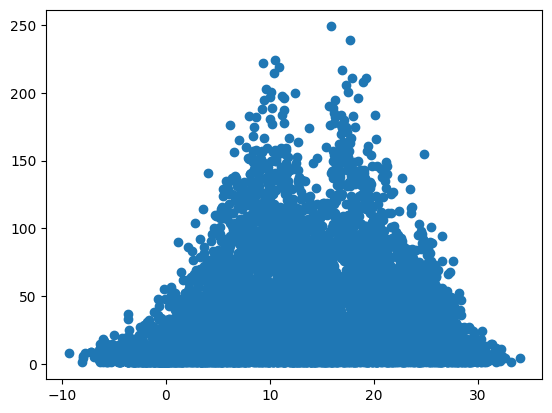

In [325]:
import matplotlib.pyplot as plt

# Charger les données dans un dataframe
dff = pd.read_csv("merge_final.csv")

# Sélectionner les colonnes de température et de nombre d'objets perdus
temperature = dff["temperature_moyenne"]
nombre_objets_perdus = dff["nb_lost_item"]

# Créer le scatterplot
plt.scatter(temperature, nombre_objets_perdus)

# Afficher le scatterplot
plt.show()


In [327]:
corq1 = dff['temperature_moyenne'].corr(dff['nb_lost_item'])

In [328]:
corq1 # c'est deja pas beaucoup 

0.07759374681026777

In [329]:
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient and the p-value
r, p = pearsonr(temperature,nombre_objets_perdus)

# Print the results
print("Pearson correlation coefficient:", r)
print("p-value:", p)


Pearson correlation coefficient: 0.07759374681026779
p-value: 8.52088385602727e-12


In [ ]:
# la p- value a l'air assez faible , mais vu le nombre de donnee on avais , on était aussi tenté de s'en passer (a ne pas faire)

Question 2 

Quelle est la médiane du nombre d’objets perdus en fonction de la saison?

Représenter cette information à l’aide d’un Boxplot. Est ce que le nombre d’objets perdus est corrélé à la saison?


In [ ]:
# de quel donnée on a besoin ? juste de la date et de la saison 
# ainsi que du nombre d'objet perdu 


In [408]:
import pandas as pd

# Load the data into a dataframe
dfr = pd.read_csv('data_objet_and_freq.csv')

# Convert the "date_heure_restitution_OT" column to datetime
dfr['date_heure_decouverte_OT'] = pd.to_datetime(df['date_heure_decouverte_OT'])

# Extract the month from the datetime objects
dfr['month'] = df['date_heure_decouverte_OT'].dt.month
dfr['day'] = df['date_heure_decouverte_OT'].dt.day

In [409]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

dfr['season'] = dfr['month'].apply(get_season)


In [336]:
dfr.columns

Index(['date_heure_decouverte_OT', 'date_heure_restitution_OT',
       'nom_gare_origine_OT', 'uic', 'nature_OT', 'type_OT', 'CP', 'an_2021',
       'an_2020', 'an_2019', 'an_2018', 'an_2017', 'an_2016', 'region_y',
       'month', 'season'],
      dtype='object')

In [337]:
# Group the data by season and type, and count the number of rows in each group
lost_objects_by_season_and_type = dfr.groupby(['season', 'type_OT']).size()


In [339]:
# Get the median for each group
# median_lost_objects_by_season_and_type = lost_objects_by_season_and_type.median()


In [340]:
# median_lost_objects_by_season_and_type

2612.5

In [342]:
aze = pd.crosstab(dfr['season'], dfr['type_OT']).apply(lambda x: x.median(), axis=1)


In [355]:
df_aze = pd.DataFrame(aze, columns=['Median Lost Objects'])


In [356]:
df_aze = df_aze.reset_index()

<AxesSubplot: xlabel='season', ylabel='Median Lost Objects'>

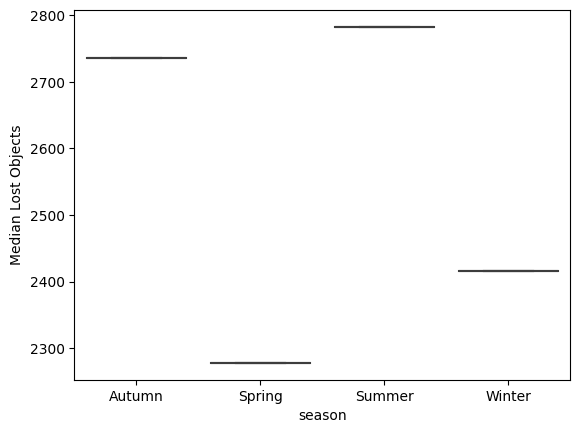

In [357]:
import seaborn as sns

sns.boxplot(x='season', y='Median Lost Objects', data=df_aze)


In [396]:
df

,date_heure_decouverte_OT,date_heure_restitution_OT,nom_gare_origine_OT,uic,nature_OT,type_OT,CP,an_2021,an_2020,an_2019,an_2018,an_2017,an_2016,region_y,month
0,2016-01-01 05:29:11,2022-12-21 11:20:58.359848,Lyon Part Dieu,87723197,Sac à dos,"Bagagerie: sacs, valises, cartables",69003.0,26187679.0,19541666.0,32587523.0,32555240.0,34874317.0,32525629.0,Auvergne-Rhône-Alpes,1
1,2016-01-01 06:44:54,2022-12-21 11:20:58.359938,Marne-la-Vallée Chessy,87111849,"Porte-monnaie, portefeuille","Porte-monnaie / portefeuille, argent, titres",77111.0,3312209.0,2492919.0,5432886.0,5996489.0,6009276.0,5418784.0,Île-de-France,1
2,2016-01-01 07:15:22,2022-12-21 11:20:58.359978,Paris Montparnasse,87391003,Autre livre,"Livres, articles de papéterie",75015.0,41043477.0,32439307.0,61374035.0,59174531.0,57752741.0,55162747.0,Île-de-France,1
3,2016-01-01 07:21:38,2022-12-21 11:20:58.360012,Paris Montparnasse,87391003,Lunettes,Optique,75015.0,41043477.0,32439307.0,61374035.0,59174531.0,57752741.0,55162747.0,Île-de-France,1
4,2016-01-01 09:32:12,2016-01-03 16:47:44.000000,Bordeaux Saint-Jean,87581009,"Ordinateur, ordinateur portable, notebook prot...","Appareils électroniques, informatiques, appare...",33800.0,16454662.0,11184093.0,17675655.0,16080989.0,14979299.0,12198403.0,Nouvelle-Aquitaine,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481297,2021-12-15 17:14:16,2022-12-21 11:26:32.384789,Mulhouse,87182063,Vélo,"Vélos, trottinettes, accessoires 2 roues",68100.0,4074689.0,3408899.0,5320370.0,5055333.0,5174727.0,4946420.0,Grand Est,12
481298,2021-12-15 17:39:56,2022-12-21 11:26:32.384817,Trouville - Deauville,87444372,Lunettes,Optique,14200.0,650092.0,493350.0,819956.0,666054.0,775823.0,734865.0,Normandie,12
481299,2021-12-15 18:47:47,2021-12-24 09:28:13.000000,Grenoble,87747006,Sac à dos,"Bagagerie: sacs, valises, cartables",38000.0,6150709.0,4781532.0,7796571.0,7057612.0,7674268.0,7237980.0,Auvergne-Rhône-Alpes,12
481300,2021-12-15 20:59:02,2022-12-21 11:26:32.384880,Angers Saint-Laud,87484006,Autres divers,Divers,49100.0,4662966.0,3433325.0,5739760.0,5372470.0,5647027.0,5368048.0,Pays de la Loire,12


In [376]:
df_onehote = pd.get_dummies(dfr, columns=['season'])

In [394]:
# Group the data by season and count the number of rows in each group
dfr['count'] = dfr.groupby(dfr["season"])['type_OT'].size()


0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
481297   NaN
481298   NaN
481299   NaN
481300   NaN
481301   NaN
Name: count, Length: 481302, dtype: float64

In [423]:
jp = dfr.groupby([dfr["day"],dfr["season"]]).apply(lambda s:pd.Series({
    "nb_objet" : s["day"].count()
}))


In [427]:
bb = jp.reset_index('season')

In [429]:
import plotly.express as px

In [ ]:
import seaborn as sns

<AxesSubplot: xlabel='season', ylabel='nb_objet'>

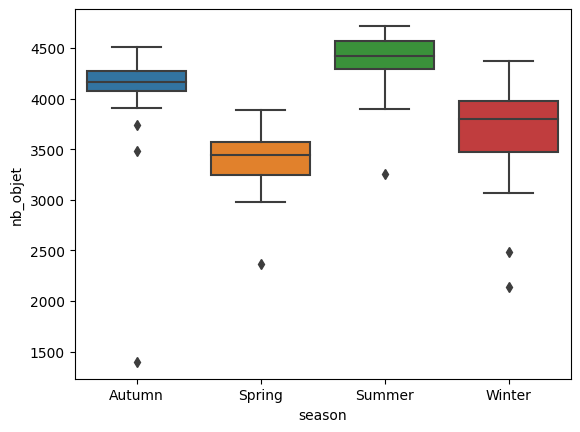

In [435]:
sns.boxplot(data=bb, x='season', y='nb_objet')
